In [250]:
import pandas as pd
import re
from unicodedata import normalize
import numpy as np

# !pip install pdfplumber
import pdfplumber

import seaborn as sns
import matplotlib.pyplot as plt

In [252]:
import warnings
warnings.filterwarnings("ignore")

Código Correcto


# ETL

In [256]:
nombresColumna = ['YEAR', 'MES', 'PRODUCTO', 'PRECIO O', 'PRECIO D', 'DIF O-D', 'DIF %', 'IPOD']
df = pd.DataFrame(columns=nombresColumna)

# Ruta al archivo
# https://coag.chil.me/post/ipod-indice-de-precios-en-origen-y-destino-de-los-alimentos-122677
ruta_pdf = "ipod historico.pdf"

In [258]:
def procesar_linea(linea, year, mes, num_precios):
    partes = linea.strip().split()
    numero_re = re.compile(r"^[\d.,]+$")

    # Inicializar el producto y el índice
    producto = partes[0]
    indice = 0

    # Buscar el primer número y agregar al producto lo que no sea número
    for j in range(1, len(partes)):
        if numero_re.match(partes[j]):  # Si encontramos un número
            break  # Salir del bucle cuando encontramos un número
        producto += " " + partes[j]  # Agregar al producto si es texto
        indice = j  # Actualizar el índice

    # Los precios empiezan después de la última posición no numérica
    precios = partes[indice + 1:indice + 1 + num_precios]  # Tomar los siguientes num_precios valores como precios
    if not precios or all(p == 'NaN' for p in precios):
        return None  # Si los precios están vacíos o solo contienen NaN, retornar None

    fila = [year, mes, producto] + [p.replace(",", ".") for p in precios]
    while len(fila) < len(nombresColumna):
        fila.append(np.nan)

    return fila


In [260]:
# Procesar todas las páginas del PDF
with pdfplumber.open(ruta_pdf) as pdf:
    for i, pagina in enumerate(pdf.pages):# i = página
        print(f"- Procesando página {i+1}/{len(pdf.pages)}", end="\r", flush=True)
        lineas = pagina.extract_text().split("\n")
        # Saltar páginas vacías o con gráficos
        #if len(lineas) <= 2 or not lineas[2].startswith("PRODUCTO"):
        if len(lineas) <= 2 or not (lineas[2].startswith("PRODUCTO") or lineas[2].startswith("PRECIO")):
          # paginas descartadas por formato: 45, 334,358,
          continue

        mes, year = lineas[0][5:].split()
        # Ajustar según el formato de página
        if i <= 3:
            inicio_datos = 4
            num_precios = 3
        else:
            inicio_datos = 6
            num_precios = 4

        for linea in lineas[inicio_datos:]:
            fila = procesar_linea(linea, year, mes, num_precios)
            if fila:
                df.loc[len(df)] = fila
                if fila[2].startswith("LECHE"):
                    break

TRATAMIENTO DE VARIABLES

In [264]:
df['PRODUCTO'] = df['PRODUCTO'].apply(lambda x: re.sub(r'\b(\w+)S\b', r'\1', x).replace('*', '').replace('(cid:3)',' '))
df['PRODUCTO'] = df['PRODUCTO'].str.rstrip()
df['DIF %'] = df['DIF %'].str.replace('%', '').astype(float)
df[['PRECIO O', 'PRECIO D','DIF O-D']] = df[['PRECIO O', 'PRECIO D','DIF O-D']].astype(float)
df['MES'] = df['MES'].str.upper()

In [266]:
df['PRODUCTO'] = df['PRODUCTO'].str.replace('TERNERA 1ª A', 'TERNERA')
df['PRODUCTO'] = df['PRODUCTO'].str.replace('TERNERA 1ª', 'TERNERA')
df['PRODUCTO'] = df['PRODUCTO'].str.replace('ACEITE DE OLIVA E V X IR T G R E A N', 'ACEITE DE OLIVA VIRGEN EXTRA')

In [268]:
#https://es.stackoverflow.com/questions/135707/c%C3%B3mo-puedo-reemplazar-las-letras-con-tildes-por-las-mismas-sin-tilde-pero-no-l
def acentos(texto):
    texto = re.sub(
        r"([^cn\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f]))|c(?!\u0327(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1",
        normalize( "NFD", texto), 0, re.I
    )
    s = normalize( 'NFC', texto)
    return texto
df['PRODUCTO'] = df['PRODUCTO'].apply(acentos)

In [270]:
df.head(4)

,YEAR,MES,PRODUCTO,PRECIO O,PRECIO D,DIF O-D,DIF %,IPOD
0,2008,JUNIO,SANDIA,0.18,1.11,6.17,NaN,NaN
1,2008,JUNIO,MELONE,0.40,1.70,4.25,NaN,NaN
2,2008,JUNIO,FRESA,1.10,2.93,2.66,NaN,NaN
3,2008,JUNIO,GARBANZO,0.60,2.23,3.72,NaN,NaN


In [272]:
df.to_csv("historico_ipod.csv", index=False)

# FIN DEL ETL

In [277]:
#df[df['PRODUCTO'].str.contains('ACEITE DE OLIVA VIRGEN', case=False, na=False)]

In [279]:
#df[df['PRODUCTO'].str.contains('SANDIA', case=False, na=False)]

In [281]:
df['dif OD revisada'] = round(df['PRECIO D'] / df['PRECIO O'],3)

In [283]:
df['dif% revisada'] = round((df['dif OD revisada'] - 1) * 100 ,3)

In [285]:
df.head(4)

,YEAR,MES,PRODUCTO,PRECIO O,PRECIO D,DIF O-D,DIF %,IPOD,dif OD revisada,dif% revisada
0,2008,JUNIO,SANDIA,0.18,1.11,6.17,NaN,NaN,6.167,516.7
1,2008,JUNIO,MELONE,0.40,1.70,4.25,NaN,NaN,4.250,325.0
2,2008,JUNIO,FRESA,1.10,2.93,2.66,NaN,NaN,2.664,166.4
3,2008,JUNIO,GARBANZO,0.60,2.23,3.72,NaN,NaN,3.717,271.7


In [287]:
df.to_csv("df_ipod_completo.csv", index=False)

In [290]:
descriptivos_procentual = df.groupby('PRODUCTO')['dif% revisada'].describe()
descriptivos_procentual.sort_values(by='count', ascending=False)[:10]

,count,mean,std,min,25%,50%,75%,max
PRODUCTO,,,,,,,,
ZANAHORIA,195.0,296.885641,201.344673,79.6,148.750,220.00,402.250,1125.0
POLLO,195.0,168.328205,43.514481,14.0,136.950,159.10,193.950,320.9
CORDERO,195.0,236.751282,66.111143,67.1,217.650,251.60,282.700,342.1
CONEJO,195.0,220.478462,40.117201,66.9,196.700,214.80,241.850,390.2
TERNERA,195.0,309.727179,27.543614,213.9,292.850,308.00,329.050,388.8
CERDO,195.0,339.216410,62.177332,213.1,286.550,337.20,381.950,486.9
CEBOLLA,195.0,473.181538,351.689591,83.3,257.300,370.80,561.900,2425.0
PLATANO,195.0,298.241026,177.819275,108.0,196.650,251.70,325.500,1550.0
PATATA,194.0,428.934536,287.907940,71.1,218.300,365.50,539.475,1450.0


In [292]:
descriptivos_procentual.to_csv("descriptivos_procentual.csv")

In [294]:
estadisticas = df.groupby(['PRODUCTO', 'YEAR'])['dif% revisada'].describe()
estadisticas = estadisticas.reset_index()
# Ordenar por 'count' (en este caso, de la columna 'Valor1') de manera descendente
estadisticas_ordenadas = estadisticas.sort_values(by=('std'), ascending=False)

estadisticas_ordenadas[:10]

,PRODUCTO,YEAR,count,mean,std,min,25%,50%,75%,max
423,LIMON,2008,3.0,1294.933333,789.655775,553.1,879.90,1206.70,1665.85,2125.0
424,LIMON,2009,12.0,921.133333,760.040524,216.7,389.10,591.25,1284.40,2760.0
278,COL,2011,3.0,743.066667,694.857060,307.4,342.40,377.40,960.90,1544.4
190,CEBOLLA,2012,12.0,850.991667,627.533420,131.1,439.60,578.10,1411.35,1940.0
580,PEPINO,2011,11.0,652.354545,618.702963,235.7,261.15,358.60,834.40,2350.0
511,MELON PIEL DE SAPO,2009,2.0,865.300000,614.758636,430.6,647.95,865.30,1082.65,1300.0
275,CLEMENTINA,2008,3.0,1010.533333,602.800177,368.0,734.00,1100.00,1331.80,1563.6
189,CEBOLLA,2011,11.0,927.854545,583.254359,303.7,549.15,841.70,1111.10,2425.0
707,SANDIA,2009,5.0,647.540000,570.052325,196.0,275.00,514.30,635.70,1616.7
184,CALABACIN BLANCO,2008,2.0,595.000000,516.187950,230.0,412.50,595.00,777.50,960.0


In [295]:
estadisticas.to_csv("estadisticas.csv")

In [296]:
temp = df[df['YEAR']=='2008']
temp.groupby(['PRODUCTO', 'YEAR'])['dif% revisada'].describe().sort_values(by=('std'), ascending=False)[:5]

,,count,mean,std,min,25%,50%,75%,max
PRODUCTO,YEAR,,,,,,,,
LIMON,2008,3.0,1294.933333,789.655775,553.1,879.90,1206.7,1665.85,2125.0
CLEMENTINA,2008,3.0,1010.533333,602.800177,368.0,734.00,1100.0,1331.80,1563.6
CALABACIN BLANCO,2008,2.0,595.000000,516.187950,230.0,412.50,595.0,777.50,960.0
SANDIA,2008,5.0,535.940000,483.379818,167.6,300.00,324.0,516.70,1371.4
CALABACIN NEGRO,2008,2.0,504.900000,385.938881,232.0,368.45,504.9,641.35,777.8


In [297]:
temp = df[df['YEAR']=='2009']
temp.groupby(['PRODUCTO', 'YEAR'])['dif% revisada'].describe().sort_values(by=('std'), ascending=False)[:5]

,,count,mean,std,min,25%,50%,75%,max
PRODUCTO,YEAR,,,,,,,,
LIMON,2009,12.0,921.133333,760.040524,216.7,389.100,591.25,1284.400,2760.0
MELON PIEL DE SAPO,2009,2.0,865.300000,614.758636,430.6,647.950,865.30,1082.650,1300.0
SANDIA,2009,5.0,647.540000,570.052325,196.0,275.000,514.30,635.700,1616.7
PATATA,2009,12.0,670.083333,458.804072,252.0,337.225,432.80,1128.575,1400.0
CEBOLLA,2009,12.0,823.066667,434.107122,194.3,538.100,792.85,1016.675,1633.3


In [298]:
temp = df[df['YEAR']=='2010']
temp.groupby(['PRODUCTO', 'YEAR'])['dif% revisada'].describe().sort_values(by=('std'), ascending=False)[:5]

,,count,mean,std,min,25%,50%,75%,max
PRODUCTO,YEAR,,,,,,,,
PLATANO,2010,11.0,494.963636,295.618803,276.1,318.600,424.20,452.700,1215.4
ALBARICOQUE,2010,2.0,429.200000,282.418448,229.5,329.350,429.20,529.050,628.9
PATATA,2010,11.0,329.509091,228.427619,82.4,168.800,337.50,396.450,900.0
ALCACHOFA,2010,8.0,363.637500,223.988194,122.3,177.000,349.55,496.775,744.0
CIRUELA,2010,4.0,212.050000,216.387839,81.1,105.625,115.70,222.125,535.7


In [300]:
df['YEAR'].unique()


array(['2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
       '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023',
       '2024'], dtype=object)

In [306]:
#df[(df['YEAR'] == '2008') & (df['MES'] == 'JUNIO')]

In [308]:
resultados = []

for (year, mes), group in df.groupby(['YEAR', 'MES']):
    group = group.reset_index(drop=True)
    # Encontrar el índice de 'TERNERA' para separar los grupos
    ternera_index = group[group['PRODUCTO'] == 'TERNERA'].index[0] if 'TERNERA' in group['PRODUCTO'].values else None

    # Separar en agricultura y ganadería (comprobado siempre hay ternera)
    if ternera_index is not None:
        agricultura = group.iloc[:ternera_index]
        ganaderia = group.iloc[ternera_index:]

    media_agricultura = agricultura['DIF O-D'].mean() if not agricultura.empty else None
    media_ganaderia = ganaderia['DIF O-D'].mean() if not ganaderia.empty else None

    producto_agricultura_max = agricultura.loc[agricultura['dif% revisada'].idxmax(), 'PRODUCTO'] if not agricultura.empty else None
    producto_ganaderia_max = ganaderia.loc[ganaderia['dif% revisada'].idxmax(), 'PRODUCTO'] if not ganaderia.empty else None

    resultados.append({
      'YEAR': year,
      'MES': mes,
      'Media Agricultura': media_agricultura,
      'Media Ganaderia': media_ganaderia,
      'Producto Agricultura Max dif% revisada': producto_agricultura_max,
      'Producto Ganaderia Max dif% revisada': producto_ganaderia_max  })

df_ipods = pd.DataFrame(resultados)
df_ipods.head()

,YEAR,MES,Media Agricultura,Media Ganaderia,Producto Agricultura Max dif% revisada,Producto Ganaderia Max dif% revisada
0,2008,AGOSTO,6.011818,2.870000,PIMIENTO CALIFORNIA VERDE,CERDO
1,2008,DICIEMBRE,5.128889,3.430000,LIMON,CERDO
2,2008,JULIO,4.785909,3.238571,CALABACIN BLANCO,TERNERA
3,2008,JUNIO,4.271600,3.045714,ACEITUNA,CERDO
4,2008,NOVIEMBRE,4.944231,3.338750,CLEMENTINA,CERDO


In [309]:
df_ipods.to_csv("df_ipods.csv")

In [312]:
# productos con mayor diferencia % de agricultura y ganaderia 
df_ipods['Producto Agricultura Max dif% revisada'].value_counts()[:5]

Producto Agricultura Max dif% revisada
CEBOLLA    21
LIMON      20
PATATA     20
AJO        18
NARANJA    14
Name: count, dtype: int64

In [314]:
df_ipods['Producto Ganaderia Max dif% revisada'].value_counts()[:5]

Producto Ganaderia Max dif% revisada
CERDO      119
TERNERA     52
CORDERO     21
CONEJO       2
PAVO         1
Name: count, dtype: int64

# Análisis gráfico de las diferencias porcentuales de precios entre Origen y Destino.

In [317]:
def grafico_alimento(alimento):
    df_alimento = df[df['PRODUCTO'] == alimento]

    plt.figure(figsize=(8, 4))
    sns.lineplot(data=df_alimento, x='YEAR', y='dif% revisada', marker='o',ci=30)
    plt.title(f"Evolución temporal de la diferencia porcentual O-D de para  {alimento} ", fontsize=14)
    plt.xlabel('Año', fontsize=12)
    plt.ylabel('dif% revisada', fontsize=12)
    plt.xticks(rotation=45)
    plt.show()

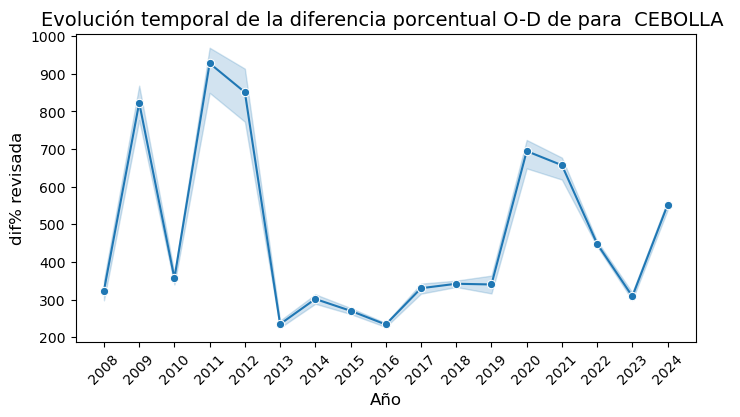

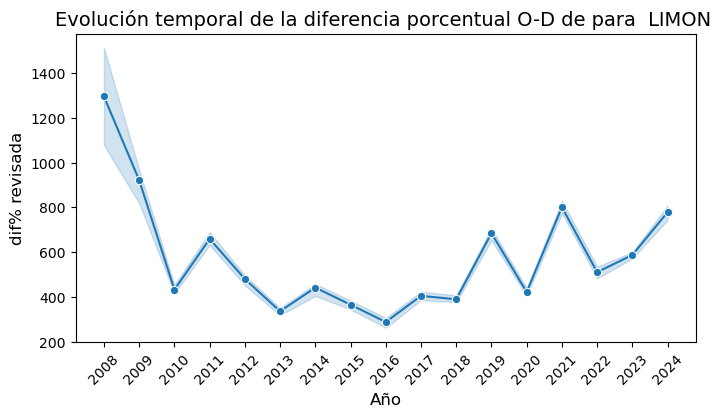

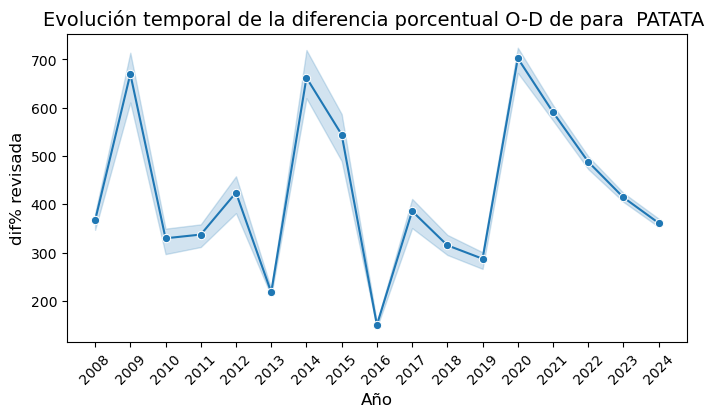

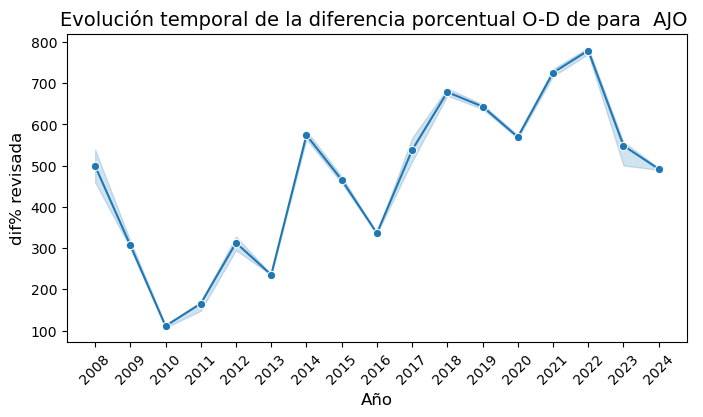

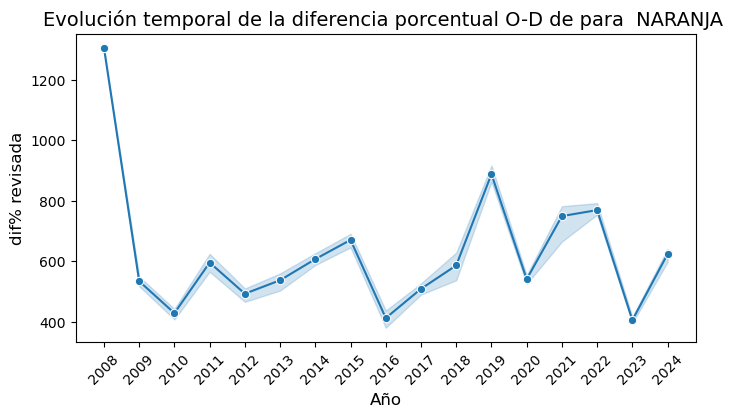

In [319]:
max_agricola=df_ipods['Producto Agricultura Max dif% revisada'].value_counts()[:5].index.tolist()
for e in max_agricola:
    grafico_alimento(e)

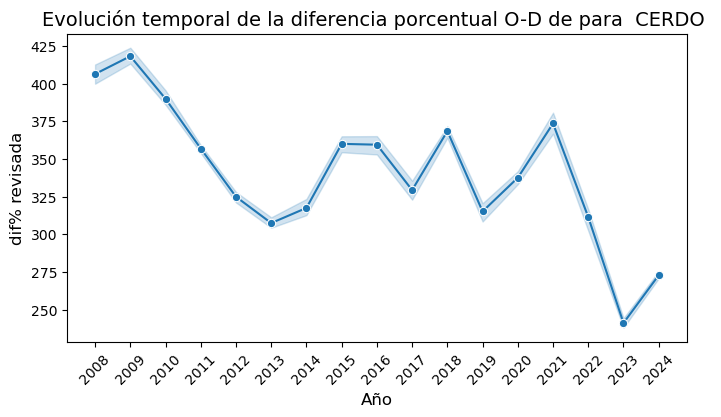

In [320]:
grafico_alimento('CERDO')

In [321]:
def grafico_grupo_alimento(grupo_alimentos):
    df_filtrado = df[df['PRODUCTO'].isin(grupo_alimentos)]

    plt.figure(figsize=(8, 6))
    sns.lineplot(data=df_filtrado, x='YEAR', y='dif% revisada', hue='PRODUCTO', marker='o',ci=40)

    plt.title("Evolución temporal de la diferencia porcentual O-D ", fontsize=14)
    plt.xlabel('Año', fontsize=12)
    plt.ylabel('dif% revisada', fontsize=12)
    plt.xticks(rotation=45)

    plt.legend(title='Producto')
    plt.show()

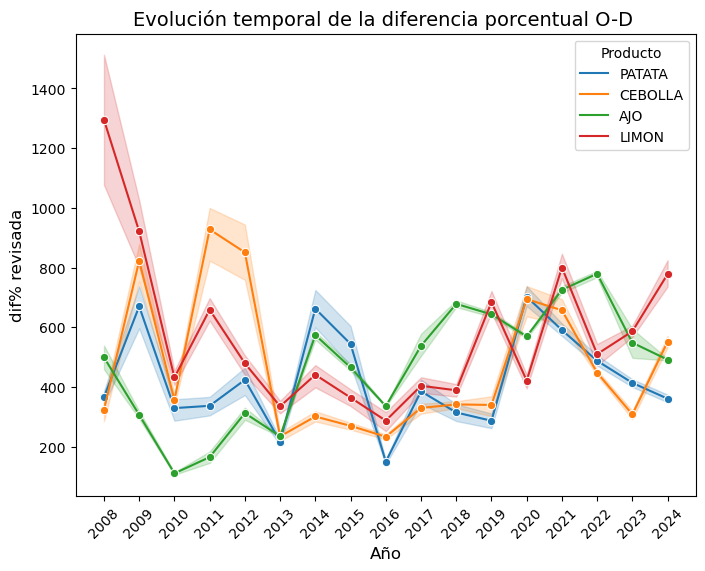

In [323]:
variables = ['CEBOLLA', 'PATATA', 'AJO', 'LIMON']
grafico_grupo_alimento(variables)

## agrupado por categorias

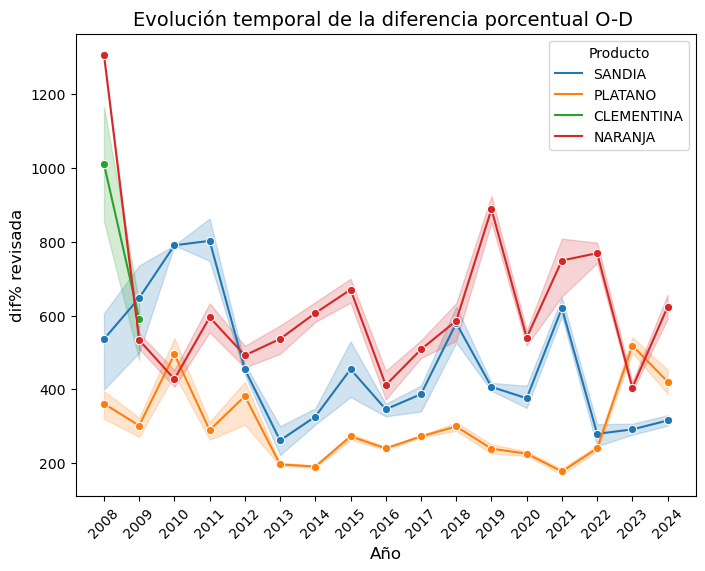

In [327]:
frutas = ['SANDIA', 'MELON', 'FRESA', 'NECTARINA', 'CIRUELA', 'CEREZA', 'PLATANO',
          'MANZANA GOLDEN', 'PERA ERCOLINA', 'UVA DE MESA', 'MANDARINA', 'CLEMENTINA',
          'LIMON FINO', 'NARANJA', 'PAPAYA', 'ALBARICOQUE', 'PARAGUAYA', 'CHIRIMOYA',
          'UVA', 'FRESON', 'MANGO', 'PARAGUAYO', 'NECATRINA']

top5_frutas = df[df['PRODUCTO'].isin(frutas)] \
                .sort_values(by='dif% revisada', ascending=False) \
                .head(5)['PRODUCTO'].tolist()
grafico_grupo_alimento(top5_frutas)

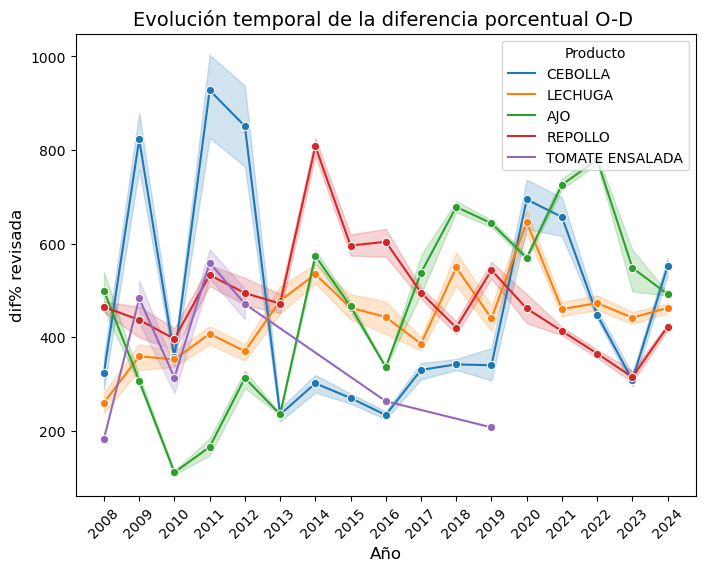

In [329]:
verduras = ['PATATA', 'CEBOLLA', 'ESPARRAGO VERDE', 'PIMIENTO ITALIANO',
            'BERENJENA', 'CALABACIN NEGRO', 'AGUACATE', 'TOMATE DE ENSALADA',
            'ZANAHORIA', 'LECHUGA ICEBERG', 'CALABACIN BLANCO', 'PEPINO',
            'PIMIENTO CALIFORNIA', 'LECHUGA', 'PUERRO', 'COL REPOLLO',
            'PIMIENTO LAMUYO', 'AJO', 'REPOLLO', 'PIMIENTO', 'ACELGA',
            'PIMIENTO CALIFORNIA VERDE', 'JUDIA VERDE', 'CALABACIN',
            'PIMIENTO CALIFORNIA ROJO', 'TOMATE ENSALADA', 'PIMIENTO VERDE',
            'PIMIENTO ROJO', 'ESPINACA', 'COLIFLOR', 'BROCOLI', 'COL',
            'CHAMPIÑON', 'COLE DE BRUSELA', 'BROCULI', 'ALCACHOFA', 'PAPA']

df_verduras = df[df['PRODUCTO'].isin(verduras)]
conteo = df_verduras['PRODUCTO'].value_counts()
productos_validos = conteo[conteo > 5].index  # problemas de datos escasos...
top5_verduras = (
    df_verduras[df_verduras['PRODUCTO'].isin(productos_validos)]
    .groupby('PRODUCTO', as_index=False)['dif% revisada'].mean()
    .sort_values(by='dif% revisada', ascending=False)
    .head(5)['PRODUCTO']
    .tolist())
grafico_grupo_alimento(top5_verduras)

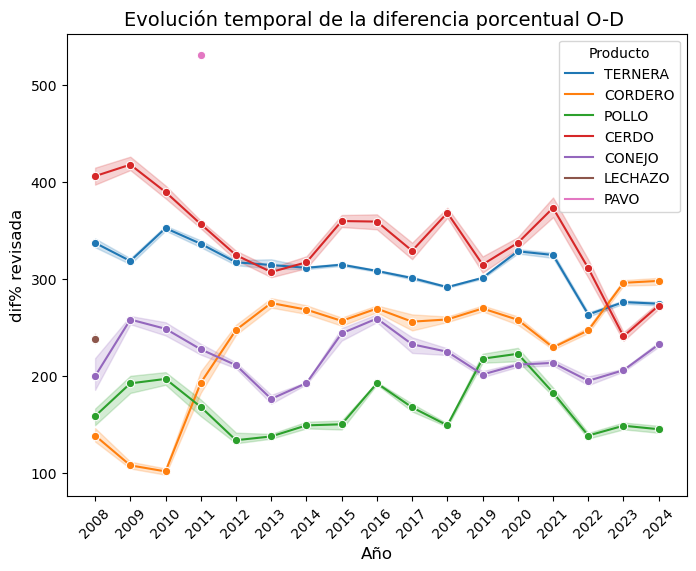

In [330]:
carnes = ['TERNERA', 'CORDERO', 'LECHAZO', 'POLLO', 'CERDO', 'CONEJO', 'PAVO']
grafico_grupo_alimento(carnes)

In [332]:
legumbres = ['GARBANZO', 'ALUBIA', 'ALUBIA VERDE', 'GUISANTE']
#grafico_grupo_alimento(legumbres)
# datos no significativos


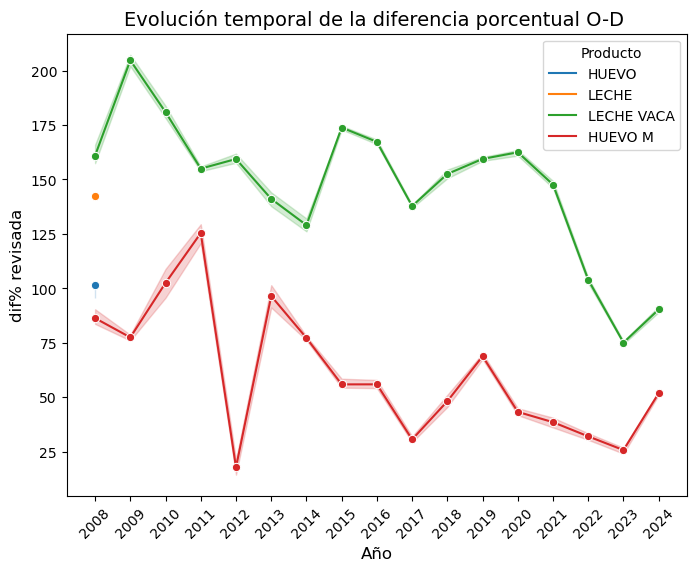

In [333]:
huevos_lacteos = ['HUEVO', 'HUEVO M', 'LECHE', 'LECHE VACA']
grafico_grupo_alimento(huevos_lacteos)

In [335]:
aceites_aceitunas = ['ACEITUNA', 'ACEITUNA VERDE', 'ACEITUNA ENTAMADA', 'ACEITUNA EN VERDE','ACEITUNA DE MESA', 'ACEITUNA (entamada)',
    'ACEITE EXTRA VIRGEN', 'ACEITE OLIVA EXTRA VIRGEN', 'ACEITE DE OLIVA VIRGEN',
    'ACEITE OLIVA VIRGEN', 'ACEITE DE OLIVA VIRGEN EXTRA', 'ACEITE OLIVA VIRGEN EXTRA',
    'ACEITE DE OLIVA E V X IR T G R E A N']
#grafico_grupo_alimento(aceites_aceitunas)
# problema de datos dispares... requiere un análisis específico

# Comparativa precio O-D unitaria 

In [341]:
def comparacion(producto):
    df_producto = df[df['PRODUCTO'] == producto]
    df_melted = df_producto[['YEAR', 'PRECIO O', 'PRECIO D']].melt(id_vars='YEAR', var_name='Variable', value_name='Valor')

    plt.figure(figsize=(8, 4))
    sns.lineplot(data=df_melted, x='YEAR', y='Valor', hue='Variable', marker='o')
    plt.title(f'Evolución de precios Origen-Destiono para {producto}')
    plt.xlabel('Año')
    plt.ylabel('Valor')
    plt.xticks(rotation=45)
    plt.legend(title='Variable')
    plt.tight_layout()
    plt.show()

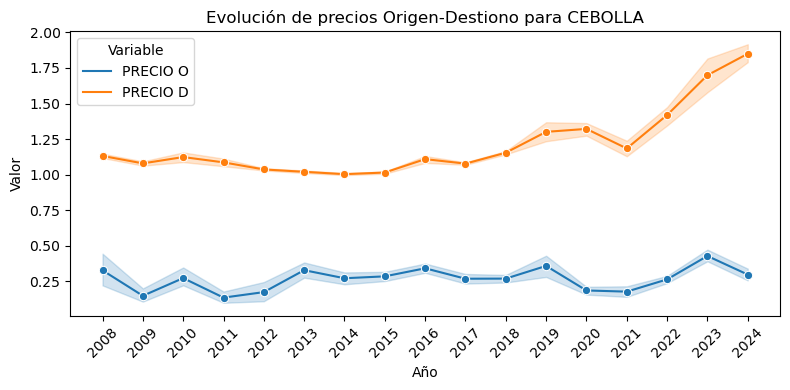

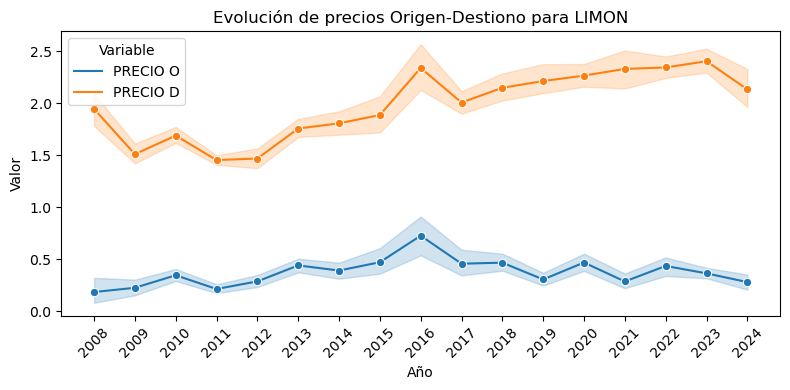

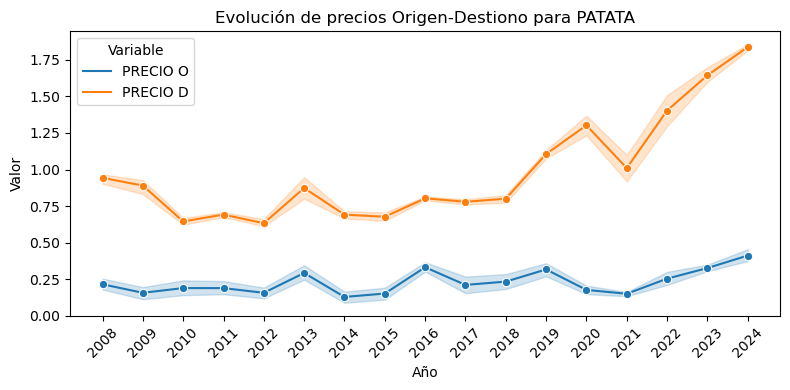

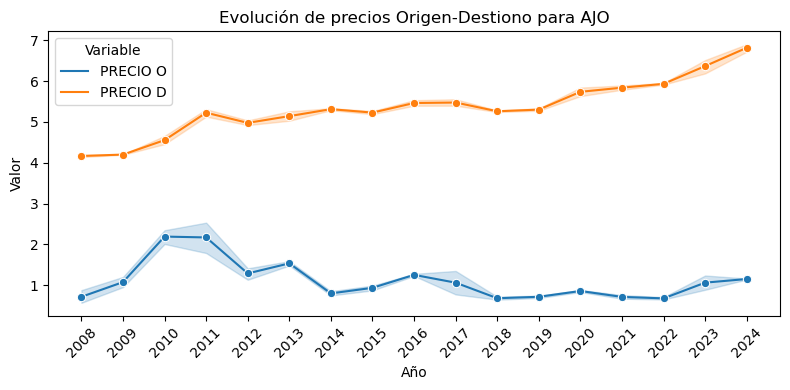

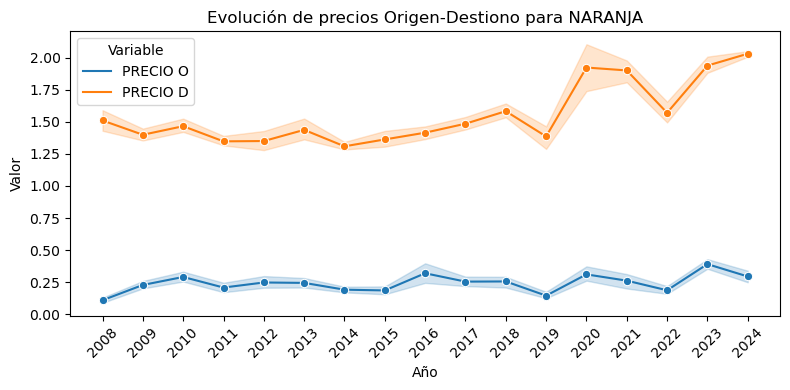

In [343]:
max_agricola=df_ipods['Producto Agricultura Max dif% revisada'].value_counts()[:5].index.tolist()
for e in max_agricola:
    comparacion(e)

In [344]:
df.to_excel("salida.xlsx")